## Data reading and Data Insights

**Concretizing the good things done during the day by writing them down participant: oceşus5g, 64 days participation**

*Dataset:*  Concretizing the good things done during the day by writing them down (A) vs Not concretizing
 the good things done during the day by writing them down (B) (continue daily routine normally) study


#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__concretizing_the_good_things_-_oceşus5g_2025-08-08 14_13_15.593//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__concretizing_the_good_things_-_oceşus5g_2025-08-08 14_13_15.593//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: feeemr5d
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [3]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '37367602-fe00-4e0c-af84-8a74d8be4a05'


#### Participation of the study

In [4]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  37367602-fe00-4e0c-af84-8a74d8be4a05                  61


During the 64-day study period, there were 3 days without any participation.

#### Missing Values

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=64, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 37367602-fe00-4e0c-af84-8a74d8be4a05 ---

  Outcome:
    Start date:           2025-06-05
    End of expected 16d:  2025-08-07
    Expected days count:  64
    Completed days count: 61
    Missed days count:    3
    Missed dates:
       2025-07-11
       2025-07-13
       2025-07-21

  Mediators:
    Start date:           2025-06-05
    End of expected 16d:  2025-08-07
    Expected days count:  64
    Completed days count: 61
    Missed days count:    3
    Missed dates:
       2025-07-11
       2025-07-13
       2025-07-21


#### Remove Participants Who Joined Outside the Study

In [6]:
#df_mea = df_mea[df_mea['participant_id'] != 'ae098342-296b-4dca-83c0-76b2f3507008']
#df_mea.shape[0]

#### Data Preperation

In [7]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(10)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-08-07 18:00:49.928075+00:00,Mediators,37367602-fe00-4e0c-af84-8a74d8be4a05,63,Avoid writing daily achievements!,NaN,NaN,NaN,NaN,5.0,6.0
1,2025-08-07 18:00:40.999485+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,63,Avoid writing daily achievements!,6.0,3.0,1.0,5.0,NaN,NaN
2,2025-08-06 18:20:42.720257+00:00,Mediators,37367602-fe00-4e0c-af84-8a74d8be4a05,62,Avoid writing daily achievements!,NaN,NaN,NaN,NaN,6.0,5.0
3,2025-08-06 18:20:34.174278+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,62,Avoid writing daily achievements!,5.0,6.0,1.0,5.0,NaN,NaN
4,2025-08-05 18:00:50.885064+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,61,Avoid writing daily achievements!,6.0,8.0,1.0,6.0,NaN,NaN
5,2025-08-05 18:00:21.750082+00:00,Mediators,37367602-fe00-4e0c-af84-8a74d8be4a05,61,Avoid writing daily achievements!,NaN,NaN,NaN,NaN,7.0,7.0
6,2025-08-04 18:10:29.847848+00:00,Mediators,37367602-fe00-4e0c-af84-8a74d8be4a05,60,Avoid writing daily achievements!,NaN,NaN,NaN,NaN,6.0,6.0
7,2025-08-04 18:10:07.110653+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,60,Avoid writing daily achievements!,5.0,6.0,1.0,5.0,NaN,NaN
8,2025-08-03 18:31:24.595570+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,59,Write down your daily achievements!,7.0,7.0,4.0,1.0,NaN,NaN
9,2025-08-03 18:31:09.072709+00:00,Mediators,37367602-fe00-4e0c-af84-8a74d8be4a05,59,Write down your daily achievements!,NaN,NaN,NaN,NaN,1.0,8.0


In [8]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [9]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [10]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
121,2025-06-05 19:06:18.923929+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,0,Write down your daily achievements!,2.0,5.0,7.0,3.0,NaN,NaN
119,2025-06-06 19:10:35.894045+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,1,Write down your daily achievements!,6.0,5.0,7.0,5.0,NaN,NaN
117,2025-06-07 18:05:54.706455+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,2,Write down your daily achievements!,4.0,5.0,4.0,4.0,NaN,NaN
114,2025-06-08 18:29:49.417148+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,3,Write down your daily achievements!,2.0,2.0,2.0,2.0,NaN,NaN
113,2025-06-09 18:56:58.295912+00:00,Outcome,37367602-fe00-4e0c-af84-8a74d8be4a05,4,Avoid writing daily achievements!,5.0,3.0,7.0,1.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)     

#### Data Shape

In [11]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 61
Columns: 11


#### Data Types of columns

In [12]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [13]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:

        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=64, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),       
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 37367602-fe00-4e0c-af84-8a74d8be4a05 ---

  Outcome:
    Start date:           2025-06-05
    End of expected 16d:  2025-08-07
    Expected days count:  64
    Completed days count: 61
    Missed days count:    3
    Missed dates:
       2025-07-11
       2025-07-13
       2025-07-21

  Mediators:
    Start date:           2025-06-05
    End of expected 16d:  2025-08-07
    Expected days count:  64
    Completed days count: 61
    Missed days count:    3
    Missed dates:
       2025-07-11
       2025-07-13
       2025-07-21

  survey1_question1_response:
    Start date:           2025-06-05
    End of expected 16d:  2025-08-07
    Expected days count:  64
    Completed days count: 61
    Missed days count:    3
    Missed dates:
       2025-07-11
       2025-07-13
       2025-07-21

  survey1_question2_response:
    Start date:           2025-06-05
    End of expected 16d:  2025-08-07
    Expected days count:  64
    Completed days count: 61
    Missed days count:    

#### Missing Values for Confirmations between 08.00 - 21.00

In [14]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=64, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 64 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

Missing participation days and their corresponding task names:
         date intervention_task_name
2  2025-06-07                    NaN


#### Summary Statistics

In [15]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             61.000000                   61.000000   
mean              31.081967                    4.622951   
std               18.954591                    2.621475   
min                0.000000                    1.000000   
25%               15.000000                    2.000000   
50%               30.000000                    5.000000   
75%               48.000000                    6.000000   
max               63.000000                   10.000000   

       survey1_question2_response  survey1_question3_response  \
count                   61.000000                   61.000000   
mean                     4.377049                    3.737705   
std                      2.395579                    2.971541   
min                      1.000000                    1.000000   
25%                      3.000000                    1.000000   
50%                      4.000000               

In [16]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 121 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            61 non-null     datetime64[ns, UTC]
 1   measurement_name            61 non-null     object             
 2   participant_id              61 non-null     object             
 3   current_day_of_study        61 non-null     int64              
 4   current_intervention_name   61 non-null     object             
 5   survey1_question1_response  61 non-null     float64            
 6   survey1_question2_response  61 non-null     float64            
 7   survey1_question3_response  61 non-null     float64            
 8   survey1_question4_response  61 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtyp

#### Data Visualization and Distributions

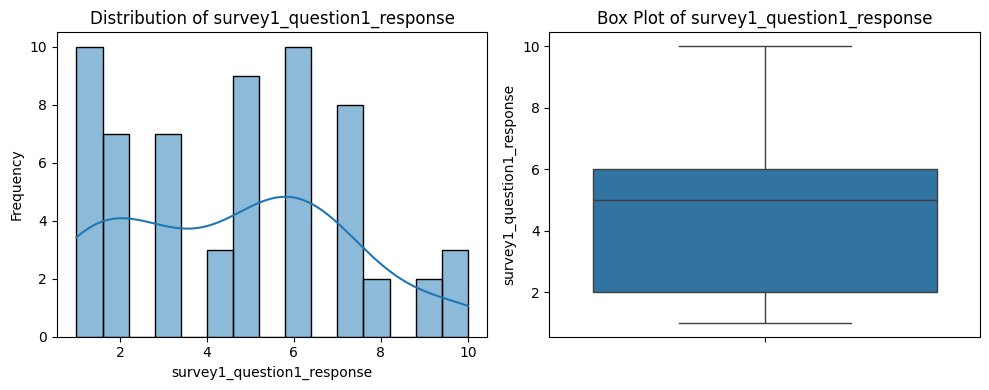

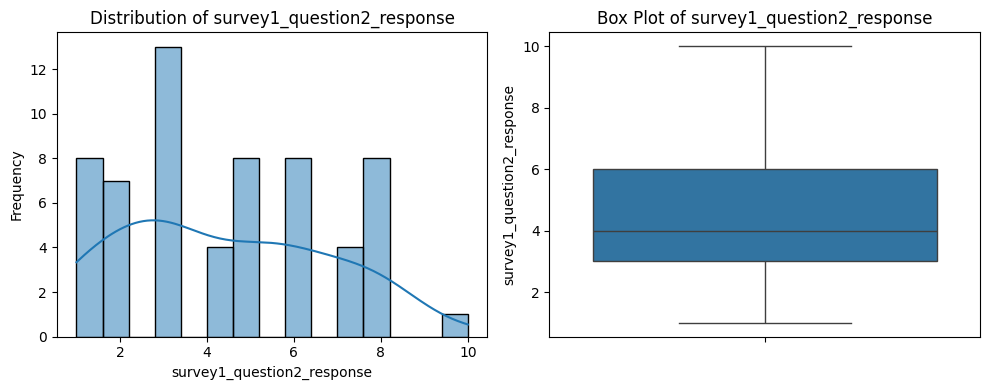

In [17]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

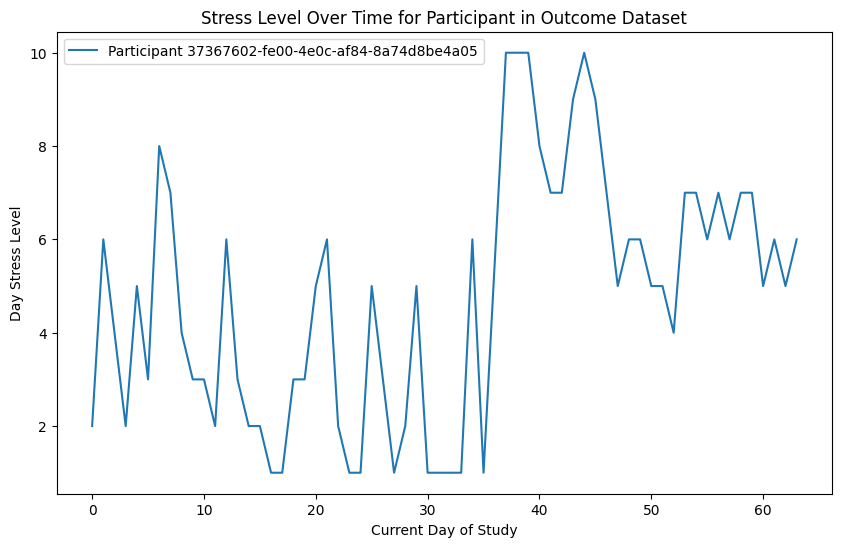

In [18]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6))

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Participant in Outcome Dataset')

plt.legend()
plt.show()

#### Scatterplot

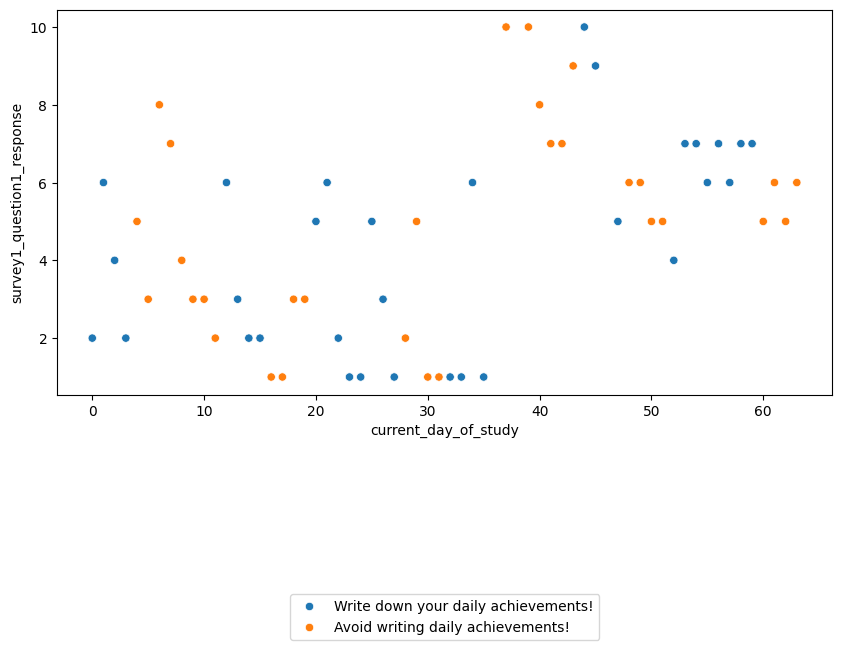

In [19]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

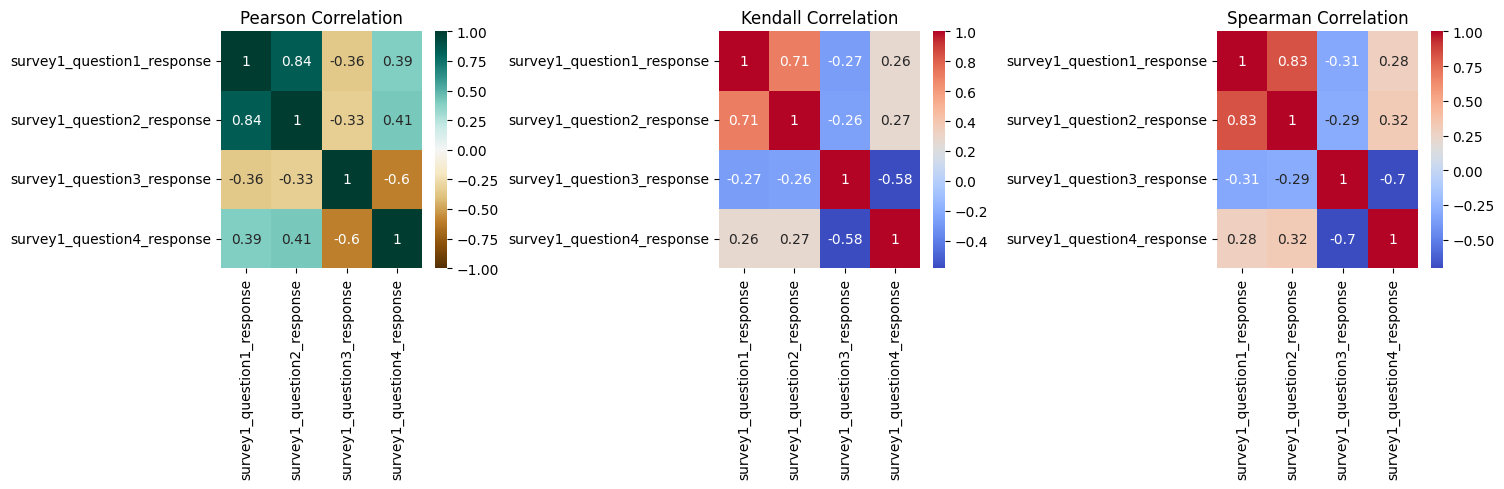

In [20]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Concretizing the good things vs Not concretizing the good things

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [21]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Write down your daily achievements!",
        "Avoid writing daily achievements!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Write down your daily achievements!",
    'survey1_question1_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid writing daily achievements!",
    'survey1_question1_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Concretizing good things:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not concretizing good things:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")


Concretizing good things:           n = 31, std = 2.61, mean = 4.35
Not concretizing good things:       n = 30, std = 2.64, mean = 4.90



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Write down your daily achievements!",
        "Avoid writing daily achievements!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Write down your daily achievements!",
    'survey1_question2_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid writing daily achievements!",
    'survey1_question2_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Concretizing good things:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not concretizing good things:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")


Concretizing good things:           n = 31, std = 2.24, mean = 4.19
Not concretizing good things:       n = 30, std = 2.57, mean = 4.57



#### Examination of Outcomes: Mean Stress-Relief Score for Concretizing good things (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much  to concretizing good things alleviated participants’ stress on days they performed.

In [23]:
df_mea.survey1_question3_text[0]

"Did your miracle stress-shrinking method help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes? <b>(1 = Not helpful at all to 10 = I'm practically levitating with calmness) <i>(Answer ONLY if you have concretized the good things done!)</i></b>"

In [24]:
# "Did your miracle stress-shrinking method help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes? <b>(1 = Not helpful at all to 10 = I'm practically levitating with calmness) <i>(Answer ONLY if you have concretized the good things done!)</i></b>"
mean_q3_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Write down your daily achievements!",
    'survey1_question3_response'
].mean()
mean_q3_concretizing.item()


5.838709677419355

**Mean Self-Improvement Score for Concretizing Good Things (Q3): 5.84:**
On days when the participant wrote down the day’s positives, she rated Question 3—“Did your miracle stress-shrinking method help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes?”—an average of **5.84 out of 10**, indicating that writing down positives provided a moderate benefit.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Concretizing Good Things (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not note positive things they have done during the day.

In [25]:
df_mea.survey1_question4_text[0]

"When you skipped the method today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b>(1 = Easy breezy to 10 = Send help, I'm barely holding it together!)  <i>(Answer ONLY if you have NOT concretized the good things done!)</i></b>"

In [26]:
# "When you skipped the method today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b>(1 = Easy breezy to 10 = Send help, I'm barely holding it together!)""
mean_q4_avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid writing daily achievements!",
    'survey1_question4_response'
].mean()
mean_q4_avoid_concretizing.item()


4.833333333333333

**Mean Stress-Management Difficulty Score Without Concretizing Good Things (Q4): 4.83:**
On days when the participant did not write down the day’s positives, she rated Question 4—“When you skipped the method today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”?”—an average of **4.83 out of 10**, indicating that skipping this practice posed a low challenge in managing her stress.


### Estimating treatment effect using Linear Regression with Autoregressive errors

In [27]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Write down your daily achievements!", "Avoid writing daily achievements!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Write down your daily achievements!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.011
Model:                                    OLS   Adj. R-squared:                 -0.006
Method:                         Least Squares   F-statistic:                    0.6556
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.421
Time:                                17:32:51   Log-Likelihood:                -144.50
No. Observations:                          61   AIC:                             293.0
Df Residuals:                              59   BIC:                             297.2
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [28]:
# GLSAR Regression with AR(1) errors (Feasible GLS)
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.006
Model:                                  GLSAR   Adj. R-squared:                 -0.011
Method:                         Least Squares   F-statistic:                    0.3653
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.548
Time:                                17:32:51   Log-Likelihood:                -130.90
No. Observations:                          60   AIC:                             265.8
Df Residuals:                              58   BIC:                             270.0
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to Concretizing the Good Thins and Mediators

Model: Neither fac1 nor fac2(intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 249 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.370  0.574    -1.473      0.796      0.020    0.016     793.0   
rho       0.586  0.109     0.379      0.810      0.005    0.004     563.0   
sigma     2.160  0.195     1.792      2.549      0.007    0.008     888.0   

          ess_tail  r_hat  
beta_int     815.0    1.0  
rho          349.0    1.0  
sigma        501.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 39.60%
P(beta_int ≤ –0.5) = 39.60%
P(–0.5 < beta_int < 0) = 34.80%
P(beta_int ≥ 0) = 25.60%


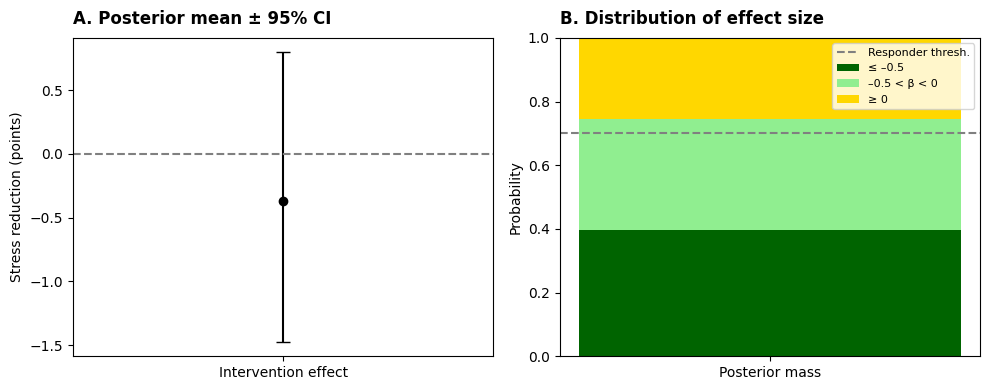

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 431 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.283  0.542    -1.344      0.765      0.018    0.016     861.0   
rho       0.569  0.119     0.336      0.802      0.005    0.006     577.0   
sigma     1.936  0.177     1.618      2.301      0.006    0.006     932.0   
beta_f1   0.437  0.101     0.242      0.621      0.004    0.003     690.0   

          ess_tail  r_hat  
beta_int     696.0   1.00  
rho          268.0   1.01  
sigma        628.0   1.00  
beta_f1      650.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 35.30%
P(beta_int ≤ –0.5) = 35.30%
P(–0.5 < beta_int < 0) = 34.60%
P(beta_int ≥ 0) = 30.10%


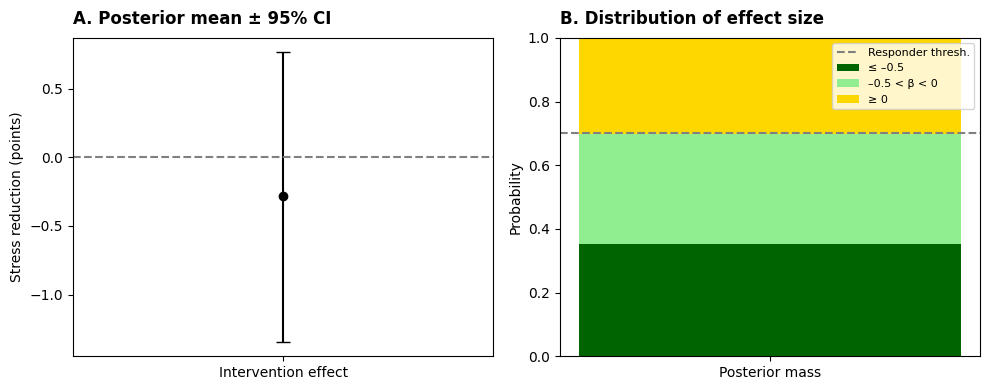

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 512 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.010  0.407    -0.836      0.742      0.014    0.015     845.0   
rho       0.285  0.134     0.017      0.542      0.005    0.004     706.0   
sigma     1.511  0.138     1.267      1.797      0.005    0.005     707.0   
beta_f2   0.844  0.093     0.663      1.028      0.004    0.003     646.0   

          ess_tail  r_hat  
beta_int     562.0   1.00  
rho          554.0   1.01  
sigma        643.0   1.00  
beta_f2      702.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 10.60%
P(beta_int ≤ –0.5) = 10.60%
P(–0.5 < beta_int < 0) = 41.00%
P(beta_int ≥ 0) = 48.40%


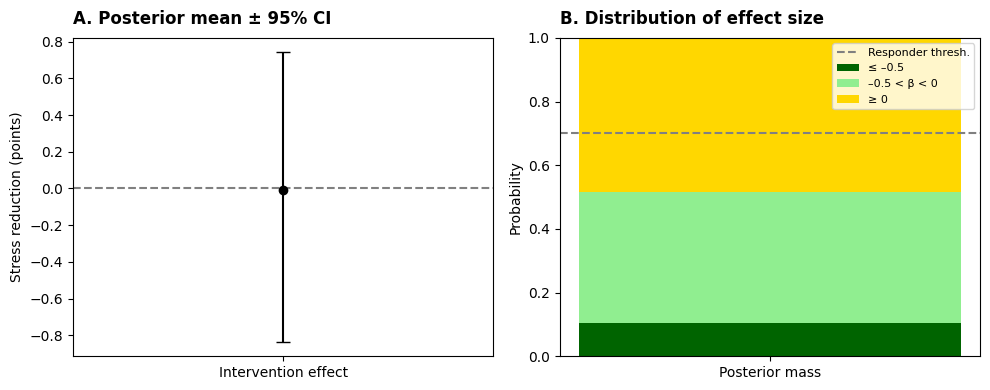

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 552 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.008  0.383    -0.761      0.713      0.012    0.017     976.0   
rho       0.272  0.138     0.004      0.549      0.005    0.005     657.0   
sigma     1.362  0.129     1.123      1.605      0.004    0.004     978.0   
beta_f1   0.282  0.069     0.158      0.435      0.002    0.002    1059.0   
beta_f2   0.756  0.087     0.582      0.920      0.003    0.002     874.0   

          ess_tail  r_hat  
beta_int     702.0   1.01  
rho          335.0   1.00  
sigma        686.0   1.00  
beta_f1      633.0   1.00  
beta_f2      787.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 8.60%
P(beta_int ≤ –0.5) = 8.60%
P(–0.5 < beta_int < 0) = 41.40%
P(beta_int ≥ 0) = 50.00%


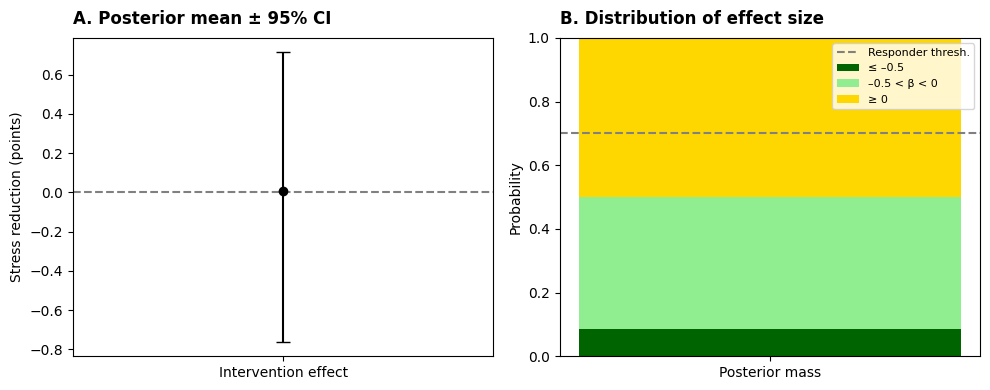

In [29]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Write down your daily achievements!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2(intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 268 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.348  0.656    -1.651      0.892      0.025    0.021     684.0   
rho       0.601  0.123     0.382      0.875      0.007    0.005     303.0   
sigma     2.235  0.212     1.828      2.656      0.008    0.008     726.0   

          ess_tail  r_hat  
beta_int     607.0   1.00  
rho          234.0   1.01  
sigma        588.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 40.10%
P(beta_int ≤ –0.5) = 40.10%
P(–0.5 < beta_int < 0) = 30.30%
P(beta_int ≥ 0) = 29.60%


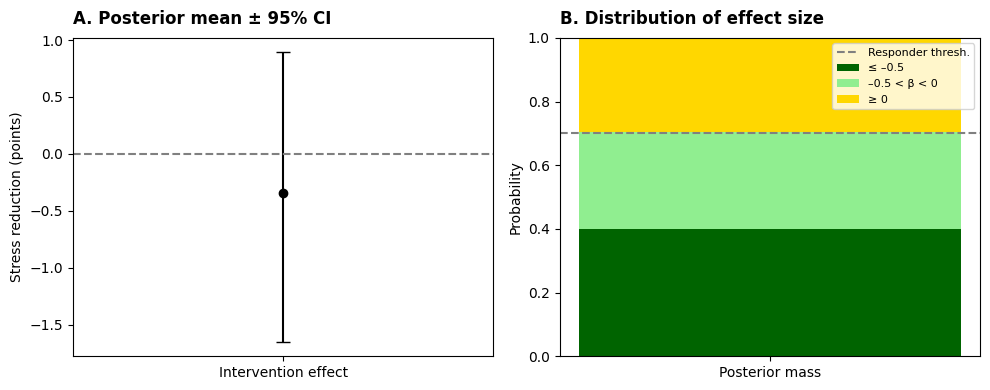


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 318 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.265  0.583    -1.293      0.949      0.019    0.017     985.0   
rho       0.579  0.123     0.322      0.804      0.006    0.006     534.0   
sigma     1.981  0.185     1.655      2.365      0.006    0.006     923.0   
beta_f1   0.459  0.100     0.278      0.657      0.003    0.003     822.0   

          ess_tail  r_hat  
beta_int     637.0    1.0  
rho          212.0    1.0  
sigma        592.0    1.0  
beta_f1      699.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 33.10%
P(beta_int ≤ –0.5) = 33.10%
P(–0.5 < beta_int < 0) = 35.00%
P(beta_int ≥ 0) = 31.90%


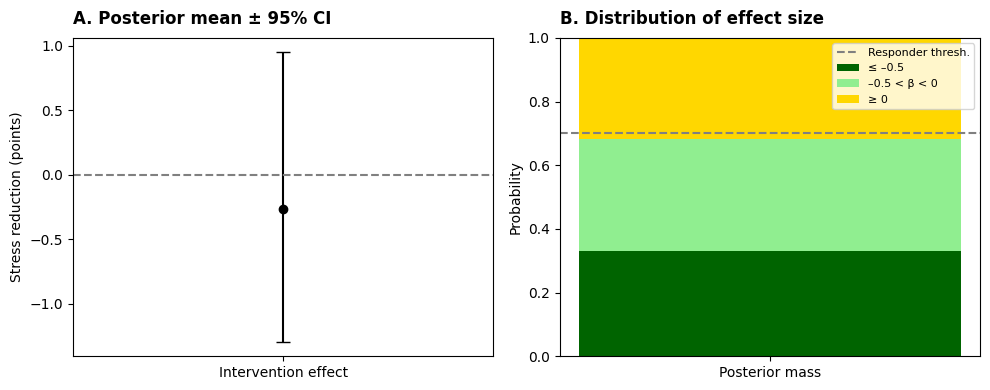


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 423 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.031  0.444    -0.848      0.851      0.015    0.013     852.0   
rho       0.287  0.130     0.050      0.540      0.005    0.004     792.0   
sigma     1.535  0.147     1.261      1.830      0.005    0.005     938.0   
beta_f2   0.851  0.093     0.668      1.032      0.003    0.003     769.0   

          ess_tail  r_hat  
beta_int     715.0   1.00  
rho          723.0   1.00  
sigma        704.0   1.00  
beta_f2      602.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 14.10%
P(beta_int ≤ –0.5) = 14.10%
P(–0.5 < beta_int < 0) = 39.40%
P(beta_int ≥ 0) = 46.50%


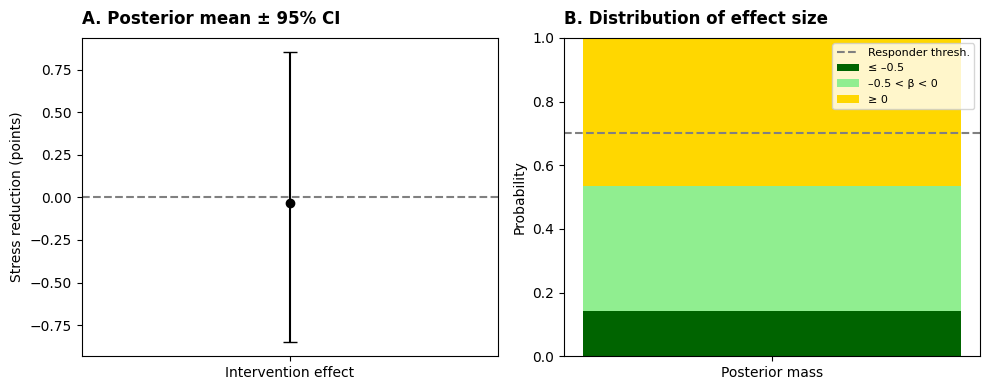


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 520 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.031  0.433    -0.874      0.809      0.017    0.013     655.0   
rho       0.272  0.135     0.016      0.544      0.005    0.005     701.0   
sigma     1.376  0.124     1.150      1.607      0.004    0.004     784.0   
beta_f1   0.280  0.075     0.125      0.415      0.003    0.003     872.0   
beta_f2   0.750  0.090     0.565      0.915      0.003    0.003     780.0   

          ess_tail  r_hat  
beta_int     595.0    1.0  
rho          481.0    1.0  
sigma        548.0    1.0  
beta_f1      625.0    1.0  
beta_f2      608.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 14.00%
P(beta_int ≤ –0.5) = 14.00%
P(–0.5 < beta_int < 0) = 38.50%
P(beta_int ≥ 0) = 47.50%


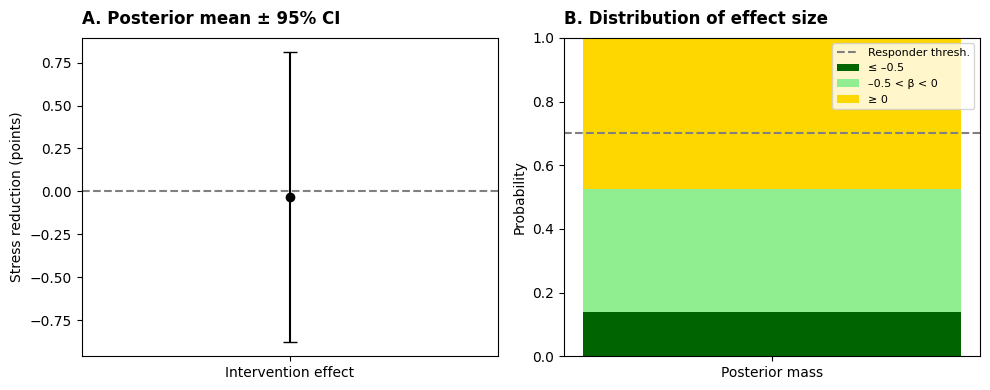

In [30]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Write down your daily achievements!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 592 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.258  0.584    -1.315      0.988      0.020    0.017     872.0   
rho       0.736  0.125     0.517      0.984      0.005    0.003     535.0   
sigma     2.109  0.195     1.769      2.507      0.007    0.006     894.0   

          ess_tail  r_hat  
beta_int     782.0   1.01  
rho          391.0   1.00  
sigma        627.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 34.20%
P(beta_int ≤ –0.5) = 34.20%
P(–0.5 < beta_int < 0) = 33.80%
P(beta_int ≥ 0) = 32.00%


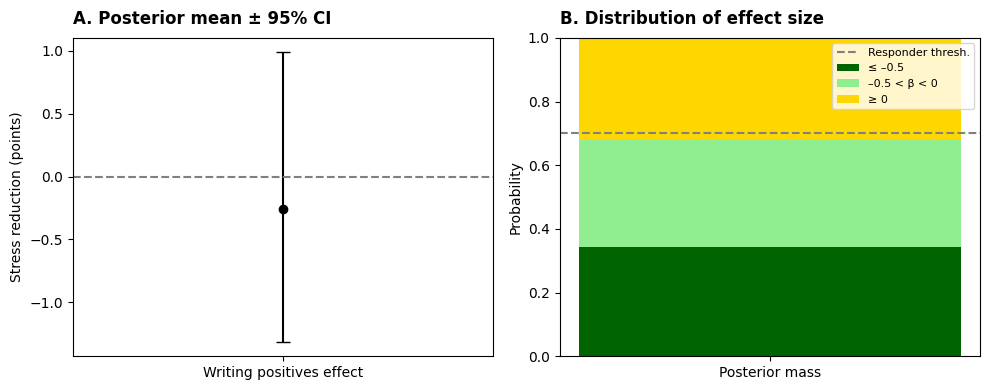


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 799 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.357  0.553    -1.409      0.768      0.017    0.018    1074.0   
rho       0.702  0.142     0.430      0.969      0.007    0.004     422.0   
sigma     1.972  0.177     1.649      2.324      0.006    0.005     940.0   
beta_f1   0.315  0.102     0.128      0.522      0.005    0.003     437.0   

          ess_tail  r_hat  
beta_int     717.0   1.00  
rho          346.0   1.01  
sigma        875.0   1.00  
beta_f1      695.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 40.10%
P(beta_int ≤ –0.5) = 40.10%
P(–0.5 < beta_int < 0) = 34.80%
P(beta_int ≥ 0) = 25.10%


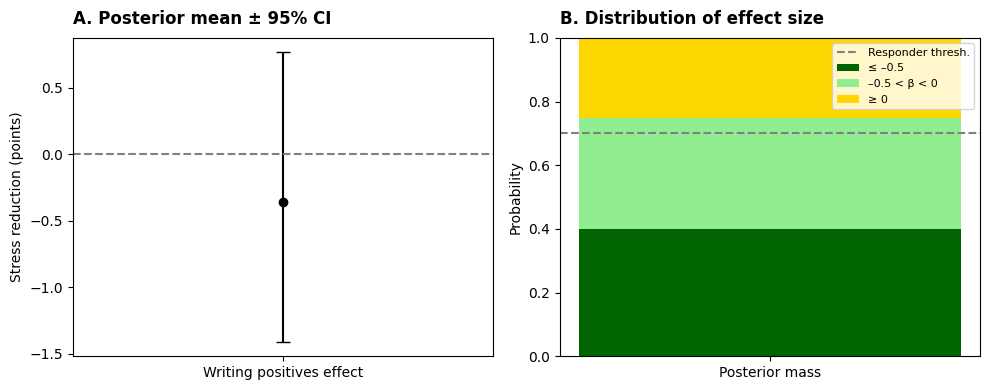


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 908 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.067  0.418    -0.821      0.815      0.013    0.013    1060.0   
rho       0.285  0.138     0.030      0.571      0.004    0.004    1073.0   
sigma     1.507  0.132     1.253      1.770      0.004    0.004     926.0   
beta_f2   0.834  0.097     0.653      1.035      0.004    0.003     602.0   

          ess_tail  r_hat  
beta_int     634.0    1.0  
rho          716.0    1.0  
sigma        577.0    1.0  
beta_f2      727.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 15.30%
P(beta_int ≤ –0.5) = 15.30%
P(–0.5 < beta_int < 0) = 41.70%
P(beta_int ≥ 0) = 43.00%


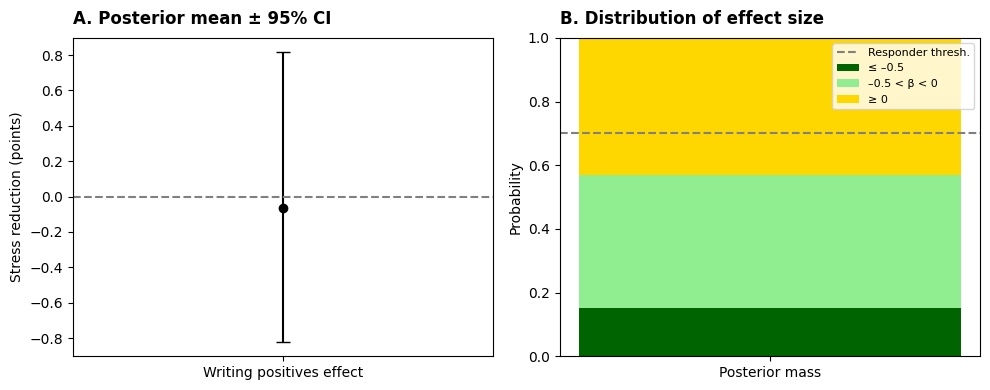


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1140 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.078  0.378    -0.774      0.692      0.011    0.014    1103.0   
rho       0.215  0.144    -0.078      0.470      0.004    0.004    1216.0   
sigma     1.378  0.134     1.139      1.644      0.004    0.005    1066.0   
beta_f1   0.266  0.071     0.118      0.394      0.002    0.002     986.0   
beta_f2   0.769  0.081     0.604      0.925      0.003    0.002     936.0   

          ess_tail  r_hat  
beta_int     638.0    1.0  
rho          822.0    1.0  
sigma        752.0    1.0  
beta_f1      642.0    1.0  
beta_f2      829.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 12.50%
P(beta_int ≤ –0.5) = 12.50%
P(–0.5 < beta_int < 0) = 45.90%
P(beta_int ≥ 0) = 41.60%


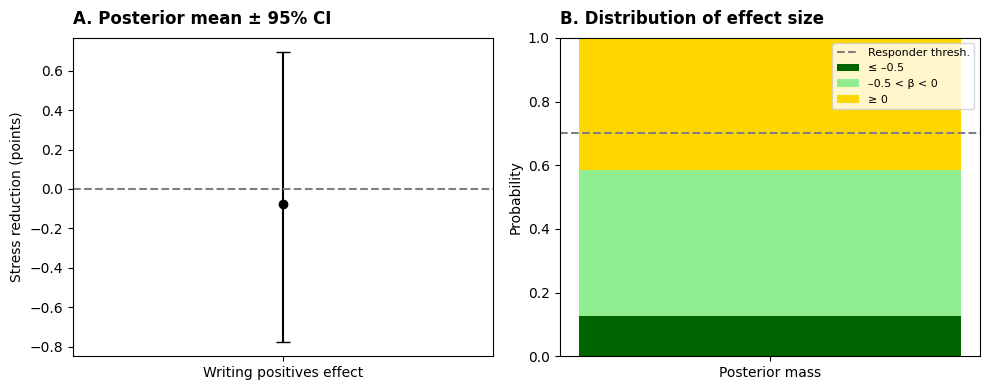

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int -0.078  0.378    -0.774      0.692      0.011    0.014    1103.0   
 rho       0.215  0.144    -0.078      0.470      0.004    0.004    1216.0   
 sigma     1.378  0.134     1.139      1.644      0.004    0.005    1066.0   
 beta_f1   0.266  0.071     0.118      0.394      0.002    0.002     986.0   
 beta_f2   0.769  0.081     0.604      0.925      0.003    0.002     936.0   
 
           ess_tail  r_hat  
 beta_int     638.0    1.0  
 rho          822.0    1.0  
 sigma        752.0    1.0  
 beta_f1      642.0    1.0  
 beta_f2      829.0    1.0  )

In [31]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 64)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Write down your daily achievements!").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Writing positives effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)


#### Bayesian AR(1) Model of Daily Stress Response to Concretizing the Good Thins and Mediators - Mean Imputation Method

In [32]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 64)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_6248\290410680.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_6248\290410680.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [33]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 +
    ['B'] * 4 +
    ['A'] * 8 +
    ['B'] * 4 +
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 +
    ['B'] * 4 +
    ['A'] * 8 +
    ['B'] * 4
)
txt = {
    'A': "Write down your daily achievements!",
    'B': "Avoid writing daily achievements!"
}

df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()  )                                 

df_fill_o = (
    df_unique_o
    .reindex(range(0, 64))                     
    .reset_index()                             
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

df_unique_m = (
    df_m
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                  
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 64))                     
    .reset_index()                             
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [34]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()
df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)

cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

Model: Neither fac1 nor fac2(intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 329 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.177  0.553    -1.363      0.778      0.022    0.016     629.0   
rho       0.558  0.111     0.337      0.756      0.004    0.004     725.0   
sigma     2.153  0.180     1.835      2.523      0.006    0.006     904.0   

          ess_tail  r_hat  
beta_int     748.0   1.01  
rho          624.0   1.00  
sigma        625.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 27.50%
P(beta_int ≤ –0.5) = 27.50%
P(–0.5 < beta_int < 0) = 36.20%
P(beta_int ≥ 0) = 36.30%


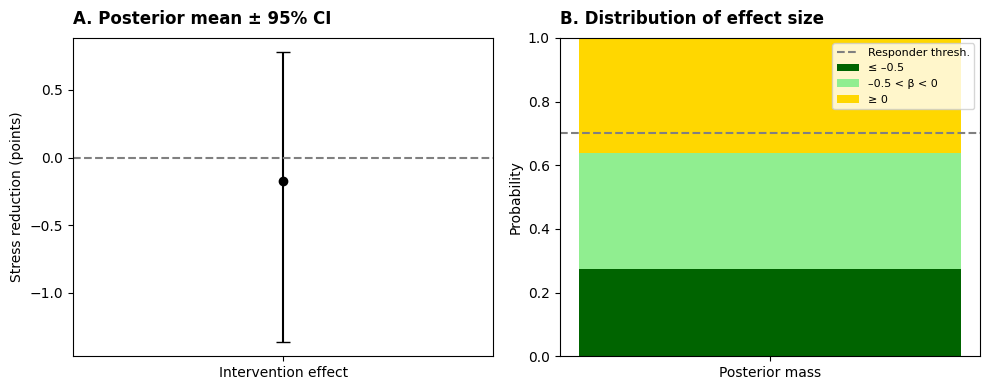

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 467 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.118  0.504    -1.108      0.809      0.017    0.014     910.0   
rho       0.490  0.111     0.266      0.696      0.003    0.004    1011.0   
sigma     1.967  0.178     1.627      2.294      0.006    0.006     900.0   
beta_f1   0.396  0.105     0.177      0.589      0.003    0.003    1003.0   

          ess_tail  r_hat  
beta_int     625.0    1.0  
rho          512.0    1.0  
sigma        574.0    1.0  
beta_f1      660.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 22.70%
P(beta_int ≤ –0.5) = 22.70%
P(–0.5 < beta_int < 0) = 36.90%
P(beta_int ≥ 0) = 40.40%


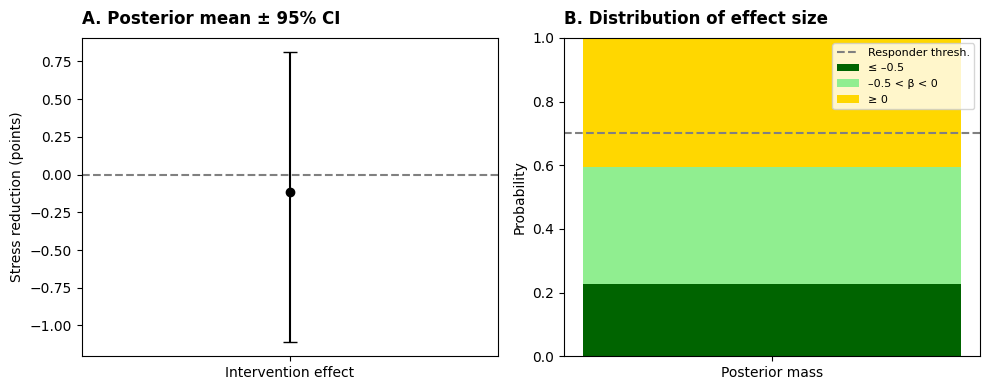

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 607 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.014  0.395    -0.788      0.713      0.013    0.012     932.0   
rho       0.276  0.126     0.042      0.533      0.004    0.004     820.0   
sigma     1.473  0.130     1.247      1.742      0.004    0.004     899.0   
beta_f2   0.847  0.092     0.660      1.015      0.004    0.003     605.0   

          ess_tail  r_hat  
beta_int     650.0    1.0  
rho          697.0    1.0  
sigma        799.0    1.0  
beta_f2      545.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 9.90%
P(beta_int ≤ –0.5) = 9.90%
P(–0.5 < beta_int < 0) = 40.30%
P(beta_int ≥ 0) = 49.80%


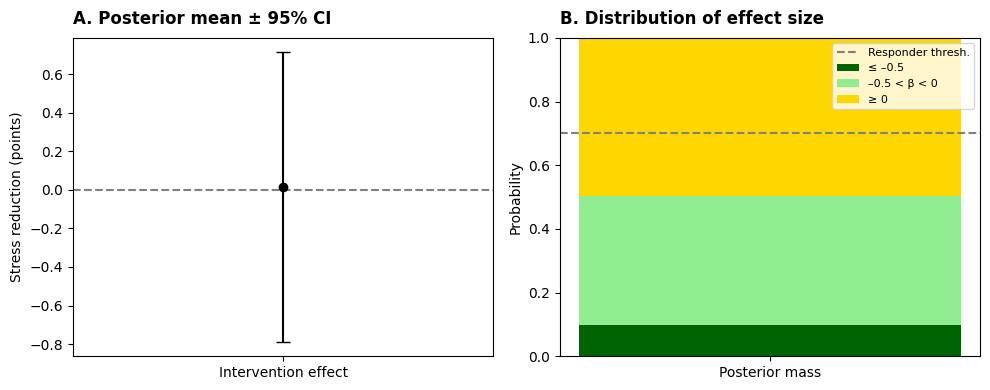

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 655 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.037  0.352    -0.632      0.740      0.011    0.011    1055.0   
rho       0.248  0.132    -0.019      0.485      0.004    0.005     965.0   
sigma     1.336  0.127     1.096      1.585      0.004    0.005    1199.0   
beta_f1   0.272  0.074     0.128      0.414      0.002    0.002    1075.0   
beta_f2   0.758  0.087     0.600      0.930      0.003    0.002     838.0   

          ess_tail  r_hat  
beta_int     718.0   1.00  
rho          511.0   1.00  
sigma        777.0   1.00  
beta_f1      644.0   1.01  
beta_f2      763.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 6.20%
P(beta_int ≤ –0.5) = 6.20%
P(–0.5 < beta_int < 0) = 39.70%
P(beta_int ≥ 0) = 54.10%


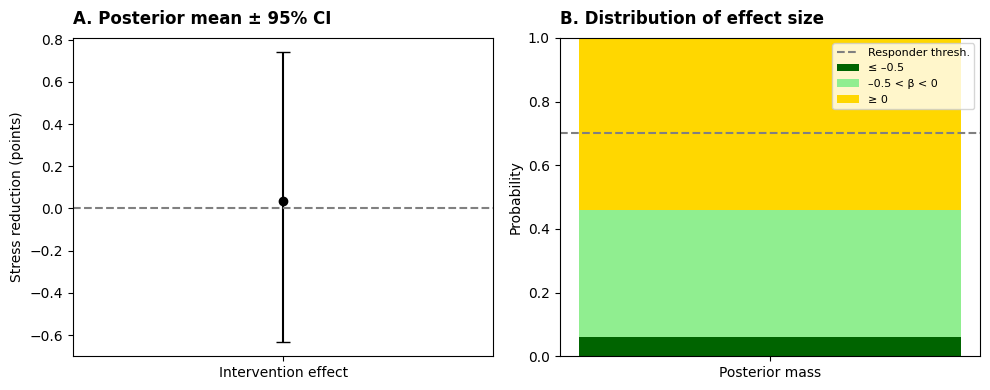

In [35]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mean_imp_o.copy()
    mediator_data = df_mean_imp_m.copy()

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Write down your daily achievements!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2(intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to Concretizing the Good Thins and Mediators - Latent Missing Method

In [36]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 64)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Write down your daily achievements!").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 769 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.175  0.560    -0.860       1.28      0.019    0.015     876.0   
rho       0.654  0.109     0.479       0.90      0.006    0.005     366.0   
sigma     1.950  0.186     1.626       2.34      0.006    0.009     940.0   

          ess_tail  r_hat  
beta_int     885.0   1.00  
rho          242.0   1.00  
sigma        503.0   1.01  
P(beta_int ≤ –0.5) = 11.30%
P(–0.5 < beta_int < 0) = 25.70%
P(beta_int ≥ 0) = 63.00%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 496 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.219  0.502    -0.685      1.283      0.018    0.015     786.0   
rho       0.567  0.098     0.381      0.747      0.004    0.003     517.0   
sigma     1.654  0.155     1.347      1.948      0.006    0.006     730.0   
beta_f1   0.445  0.090     0.271      0.619      0.003    0.002     705.0   

          ess_tail  r_hat  
beta_int     875.0   1.01  
rho          430.0   1.00  
sigma        680.0   1.00  
beta_f1      787.0   1.00  
P(beta_int ≤ –0.5) = 7.00%
P(–0.5 < beta_int < 0) = 27.40%
P(beta_int ≥ 0) = 65.60%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1056 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.037  0.409    -0.792      0.790      0.012    0.013    1124.0   
rho       0.193  0.135    -0.046      0.473      0.007    0.004     380.0   
sigma     1.512  0.140     1.251      1.793      0.004    0.005    1034.0   
beta_f2   0.827  0.098     0.637      1.018      0.004    0.003     510.0   

          ess_tail  r_hat  
beta_int     795.0    1.0  
rho          392.0    1.0  
sigma        687.0    1.0  
beta_f2      604.0    1.0  
P(beta_int ≤ –0.5) = 9.50%
P(–0.5 < beta_int < 0) = 37.90%
P(beta_int ≥ 0) = 52.60%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1265 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.117  0.369    -0.617      0.838      0.013    0.013     836.0   
rho       0.256  0.118     0.018      0.475      0.005    0.004     514.0   
sigma     1.304  0.114     1.101      1.545      0.004    0.004     919.0   
beta_f1   0.322  0.071     0.171      0.454      0.002    0.003     995.0   
beta_f2   0.679  0.094     0.497      0.865      0.003    0.003     771.0   

          ess_tail  r_hat  
beta_int     640.0   1.00  
rho          497.0   1.01  
sigma        747.0   1.00  
beta_f1      693.0   1.00  
beta_f2      755.0   1.01  
P(beta_int ≤ –0.5) = 4.60%
P(–0.5 < beta_int < 0) = 32.80%
P(beta_int ≥ 0) = 62.60%
